# Регрессия на основе гауссовских процессов

Поставим следующую задачу регрессионного анализа: пусть даны моменты времени $t_1, \dots, t_n$ и значения некой физической величины в эти моменты времени $x_1, \dots, x_n$. Нужно оценить значение этой величины в произвольный момент времени $t$. 

Если бы исходная величина была бы зашумлённой линейной (или скажем, полиномиальной) относительно времени, то это была бы постановка задачи линейной (полиномиальной) регресси, которую обычно решают методом наименьших квадратов. 

Мы же будем предполагать, что $x_1, \dots, x_n$ -- это измерения некоторого стационарного гауссовского процесса $(X_t, t \geq 0)$. Так как $EX_t$ не зависит от времени и никакого априорного знания мы о нём не имеем, в данном задании в целях эксперимента будем считать, что $EX_t = 0$. С ковариационной функцией гауссовского процесса всё сложнее, и обычно её подбирают под исходные данные, поэтому мы оформим её вызов в отдельную функцию, и пока будем считать, что $R(t) = \exp(-t^2/2)$.

Обозначим 
$$\mathbf{X} = \begin{pmatrix} X_{t_1} \\ \vdots \\ X_{t_n} \end{pmatrix}$$
$$X_* = X_{t_*}$$

$$K = \begin{pmatrix} R(t_1, t_1)& R(t_1, t_2)& \dots& R(t_1, t_n) \\ R(t_2, t_1)& R(t_2, t_2)& \dots& R(t_2, t_n) \\ \vdots& \vdots& \ddots& \vdots \\ R(t_n, t_1)& R(t_n, t_2)& \dots& R(t_n, t_n) \end{pmatrix}$$

$$K_* = \begin{pmatrix} R(t_1, t_*) \\ R(t_2, t_*) \\ \vdots \\ R(t_n, t_*) \end{pmatrix}$$
Тогда
$$
\begin{pmatrix}
\mathbf{X} \\
X_*
\end{pmatrix}
\sim N(0, 
\begin{pmatrix}
K& K_* \\
{K_*}^T & R(t_*, t_*)\\
\end{pmatrix}
)$$
Мы хотим найти условноую плотность 
$$f(x_* | x_1, \dots, x_n) = \frac{f_{(X_{t_*}, X_{t_1}, \dots, X_{t_n})}(x_*, x_1, \dots, x_n)}{f_{(X_{t_1}, \dots, X_{t_n})}(x_1, \dots, x_n)}$$
Во первых, прологарифмируем равенство, а во вторых, поскольку нас интересует зависимость лишь от $x_*$, то все равенства будем писать с точностью до аддитивной константы (мультипликативной если не логарифмировать).

$$\log f(x_*|x_1, \dots, x_n) = - \frac{1}{2} {\begin{pmatrix}
\mathbf{x} \\
x_*
\end{pmatrix}}^{T}
{\begin{pmatrix}
K& K_* \\
{K_*}^T & R(t_*, t_*)\\
\end{pmatrix}}^{-1}
\begin{pmatrix}
\mathbf{X} \\
X_*
\end{pmatrix} = -\frac{1}{2}(a x_*^2 + b x_* + c) = -\frac{1}{2}(a (x_*^2 - 2 \frac{-b}{2a} x_* + \frac{c}{a})) = -\frac{1}{2} a (x_* - \frac{-b}{2a})^2 + const = -\frac{(x_* - \mu)^2}{2 \sigma^2}$$

Наша задача -- найти $\mu$ и $\sigma^2$. Пока мы знаем, что $\sigma^2 = \frac{1}{a}, \mu = \frac{-b}{2a}$. Пусть матрице
$${\begin{pmatrix}
K& K_* \\
K_*^T & R(t_*, t_*) \\
\end{pmatrix}}^{-1}
 = \begin{pmatrix}
A & B\\
B^T & C\\
\end{pmatrix}
$$ соответствует квадратичная форма $Q$.
Тогда $$Q(\mathbf{x}, x_*) = \mathbf{x}^T A \mathbf{x} + \mathbf{x}^T B x_* + x_* B^T \mathbf{x} + C x_*^2 = C x_*^2 + x_* (\mathbf{x}^T B + B^T \mathbf{x}) + \mathbf{x}^T A \mathbf{x}$$
Значит, $$a = C, b = (\mathbf{x}^T B + B^T \mathbf{x}) = ( (B^T \mathbf{x})^T +  B^T \mathbf{x}) = 2B^T \mathbf{x} = 2 \mathbf{x}^T B $$
Последнее верно, так как транспонированный скаляр -- это тот же самый скаляр. Воспользуемся формулами для обращения блочной матрицы (https://en.wikipedia.org/wiki/Block_matrix). Тогда мы имеем:
$$a = C = (R(0) - K_*^T K^{-1} K_*)^{-1}$$
$$B = -K^{-1} K_* C$$

Тогда $$\sigma^2 = R(0) - K_*^T K^{-1} K_*$$
$$\mu = -\frac{\mathbf{x}^T B}{C} = \mathbf{x}^T K^{-1} K_* = K_*^T K^{-1} \mathbf{x}$$

Итак, $$(X_{t_*} | X_{t_1}, \dots, X_{t_n}) \sim N(K_*^T K^{-1} \mathbf{x}, R(0) - K_*^T K^{-1} K_*)$$

# Реализация

In [70]:
%matplotlib inline

import numpy as np
from sklearn.gaussian_process import GaussianProcess
from matplotlib import pyplot as pl
np.random.seed(1)

def covm(times):
    return np.exp(-np.subtract.outer(times, times) ** 2 / 2)

def cov(time, times):
    return np.exp(- (times - time) ** 2 / 2)

def gregression_simple(times, values, time):
    values = np.atleast_2d(values).T
    K = covm(times)
    Kinv = np.linalg.inv(K)
    Kstar = np.atleast_2d(cov(time, times)).T
    Rzero = np.atleast_2d(cov(time, np.array([time])))
    mu = np.dot(np.dot(Kstar.T, Kinv), values).ravel()
    sigmasq = (Rzero - np.dot(np.dot(Kstar.T, Kinv), Kstar)).ravel()
    return (mu[0], sigmasq[0])

# Тестирование

Тестирование будем проводить на функции
$$f(x) = \log (1 + x) + ax + b \sin(cx)$$
для $$(a, b, c) \in \{0, 0.02\} \times \{0.5, 0.3\} \times \{2, 0.5\}$$
Алгоритм будет знать значения в точках $\{1, 4, 7, 8, 9, 10, 17\}$. Первые три расположены на расстоянии 3 друг от друга, следующие 4 на расстоянии 1 и последняя на расстоянии 7. Будет интересно посмотреть, как алгоритм работает, имея в своём распоряжении "много информации" (средние точки), "мало" (крайняя точка) и "достаточно" (первые точки).

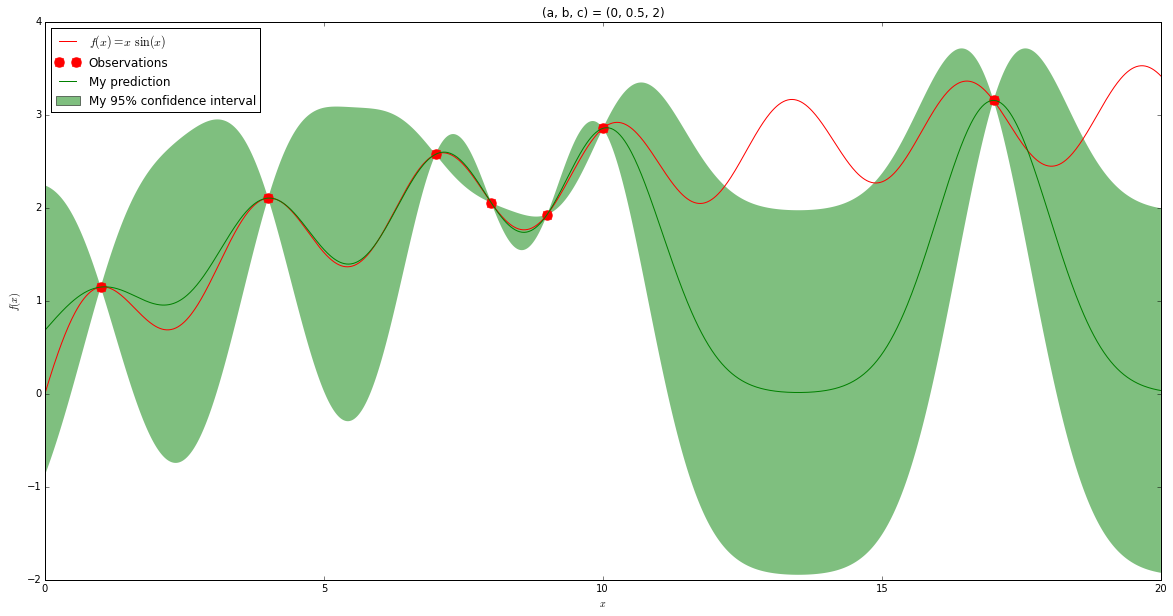

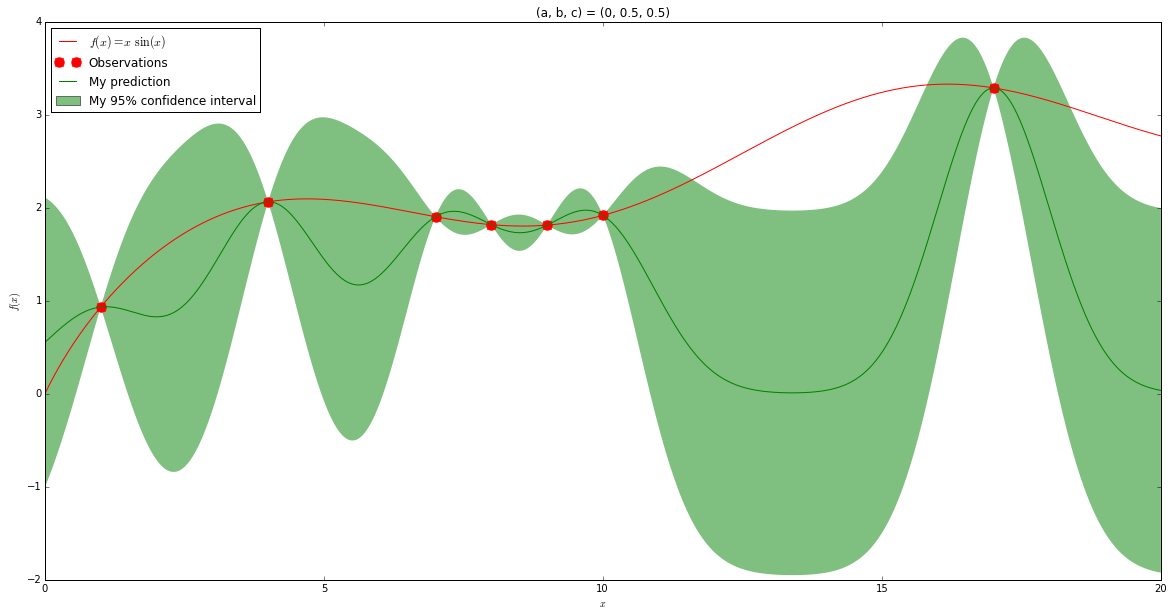

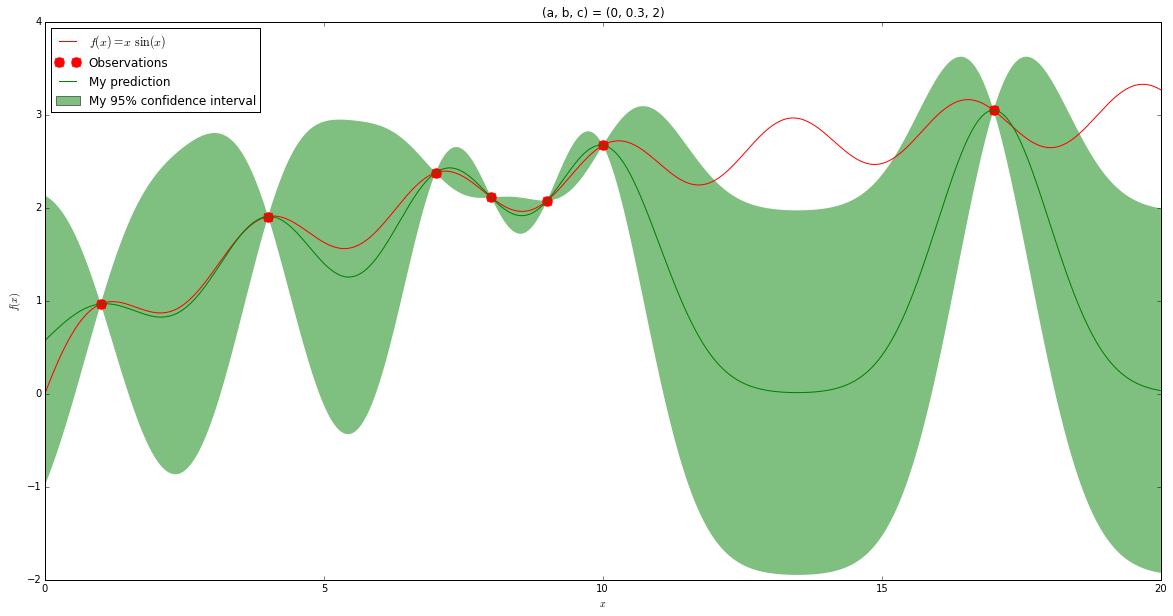

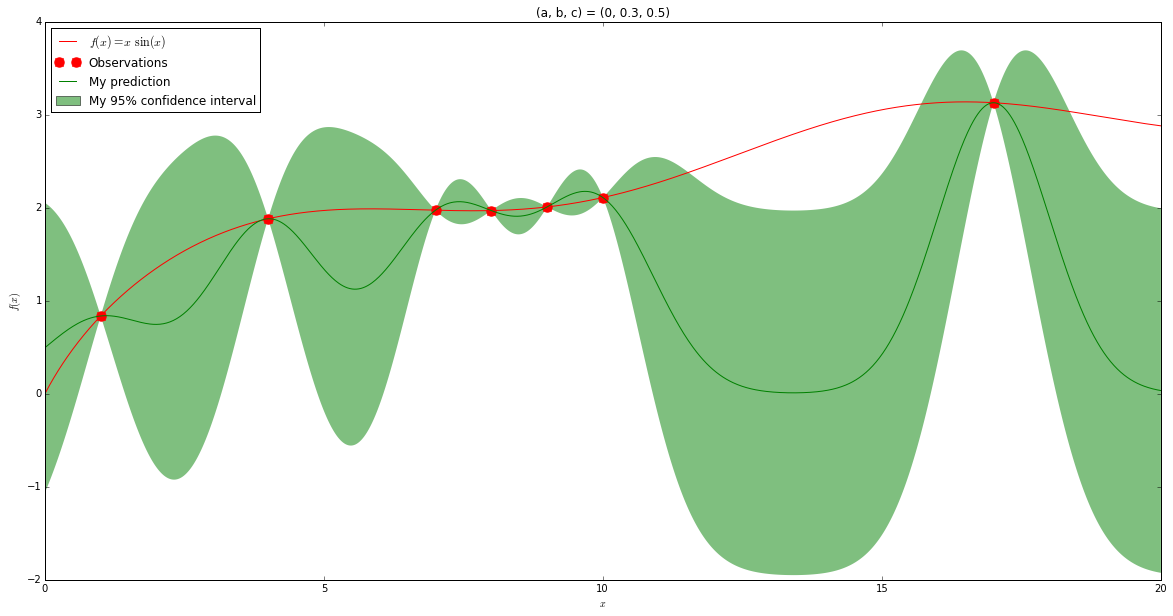

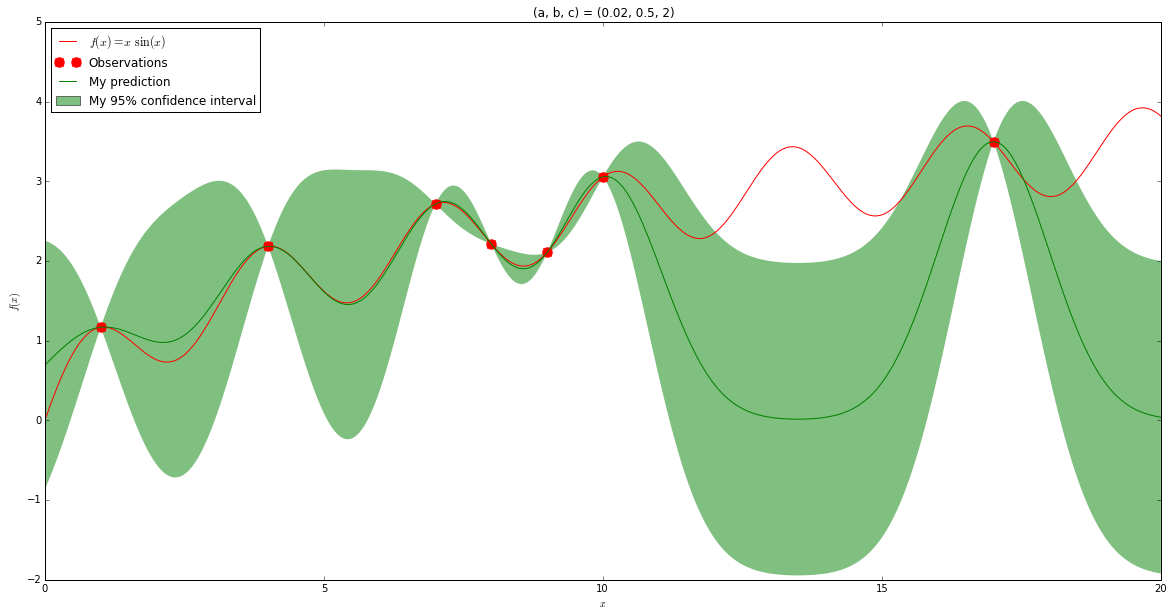

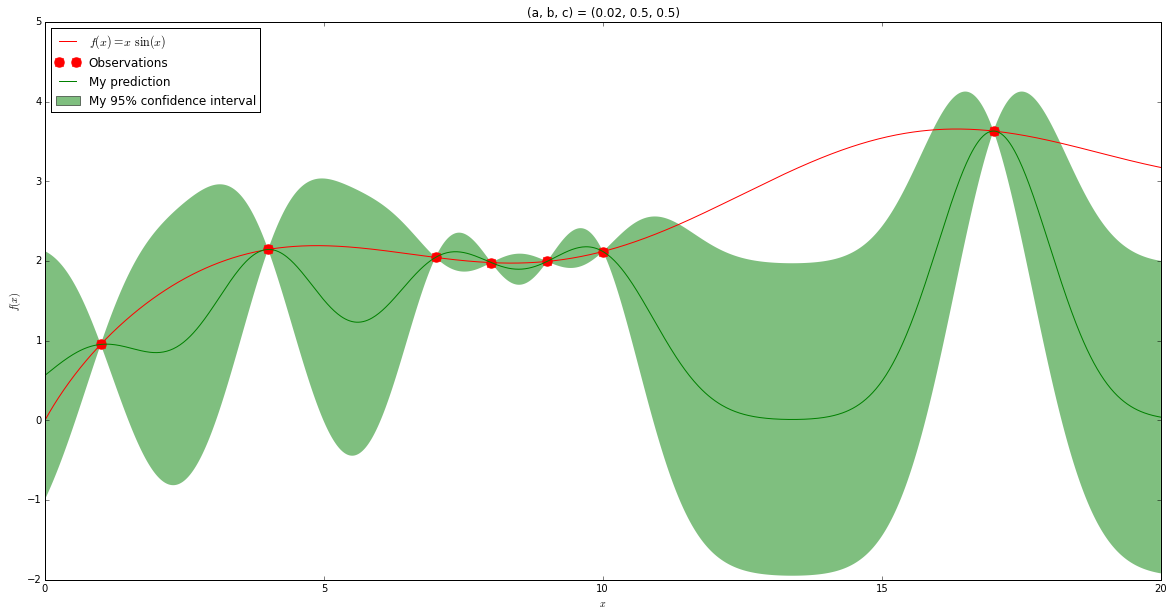

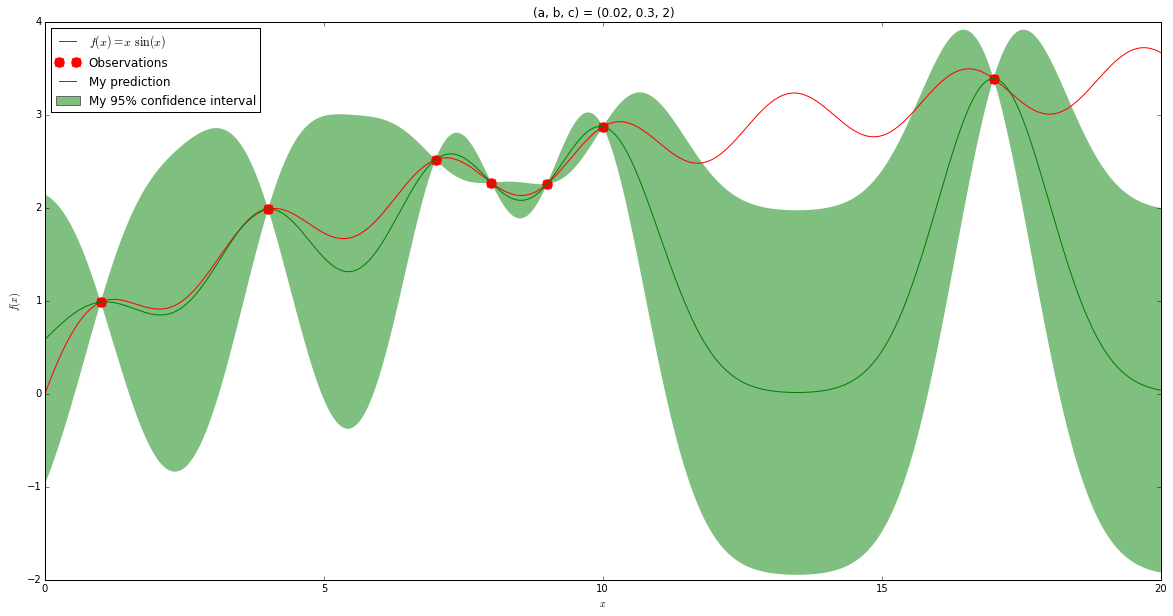

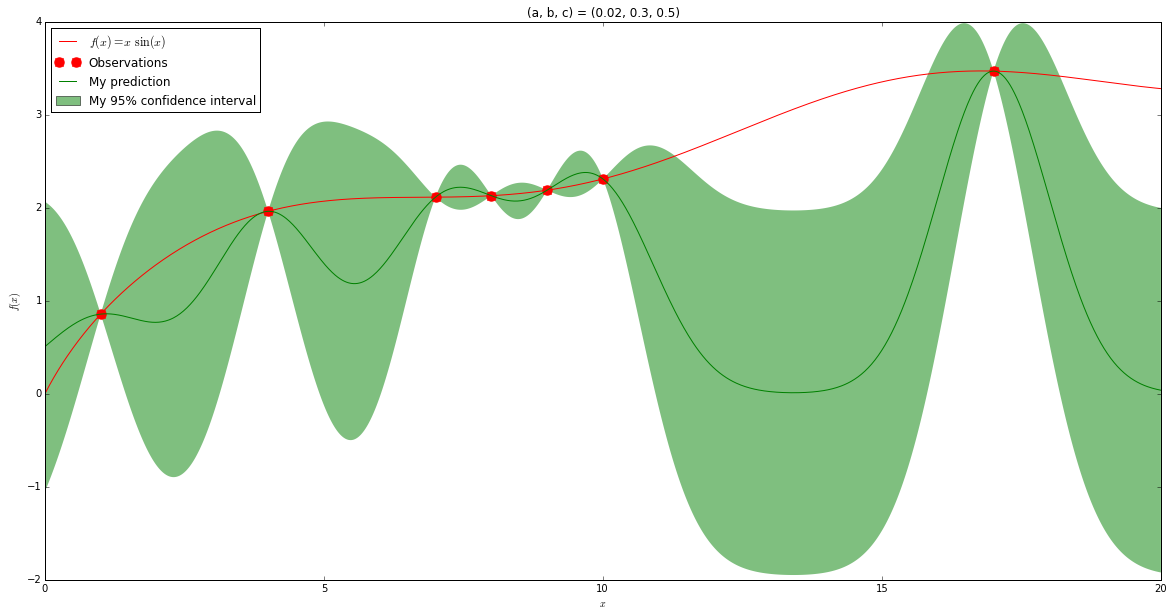

In [72]:
def test(regr, a, b, c):
    X = np.array([1., 4., 7., 8., 9., 10., 17.])
    f = lambda x: np.log(1 + x) + a * x + b * np.sin(c * x)
    y = f(X).ravel()
    x = np.atleast_2d(np.linspace(0, 20, 1000)).T

    mypreds = list(map(lambda x: regr(X, y, x), x))
    my_y_pred = np.array([x for x,_ in mypreds])
    my_sigma = np.sqrt(np.array([y for _,y in mypreds]))

    pl.figure(figsize = (20, 10))
    pl.title("(a, b, c) = " + str((a, b, c)))
    pl.plot(x, f(x), 'r', label=u'$f(x) = x\,\sin(x)$')
    pl.plot(X, y, 'r.', markersize=20, label=u'Observations')
    pl.plot(x, my_y_pred, 'g-', label=u'My prediction')
    pl.fill(np.concatenate([x, x[::-1]]),
            np.concatenate([my_y_pred - 1.9600 * my_sigma,
                           (my_y_pred + 1.9600 * my_sigma)[::-1]]),
            alpha=.5, fc='g', ec='None', label='My 95% confidence interval')

    pl.xlabel('$x$')
    pl.ylabel('$f(x)$')
    pl.legend(loc='upper left')
    pl.show()

    
for a in [0, 0.02]:
    for b in [0.5, 0.3]:
        for c in [2, 0.5]:
            test(gregression_simple, a, b, c)

Видно, что, поскольку мы считали, что $EX_t = 0$, то в точках, где мало информации, предсказание "скатывается" в ноль. Можно сделать умнее. Посчитать выборочное среднее точек, которые нам дали, пусть это $a$. Тогда будем считать, что $EX_t = a$. В этом случае формула для условной плотности выглядит так: 
$$(X_{t_*} | X_{t_1}, \dots, X_{t_n}) \sim N(a + K_*^T K^{-1} (\mathbf{x} - \mathbf{a}), R(0) - K_*^T K^{-1} K_*)$$
Это доказывается аналогичным образом (или можно как тут http://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution)

# Тестирование улучшенной версии

In [74]:
def gregression_smart(times, values, time):
    a = np.average(values)
    values = np.atleast_2d(values).T
    K = covm(times)
    Kinv = np.linalg.inv(K)
    Kstar = np.atleast_2d(cov(time, times)).T
    Rzero = np.atleast_2d(cov(time, np.array([time])))
    mu = a + np.dot(np.dot(Kstar.T, Kinv), values - a).ravel()
    sigmasq = (Rzero - np.dot(np.dot(Kstar.T, Kinv), Kstar)).ravel()
    return (mu[0], sigmasq[0])

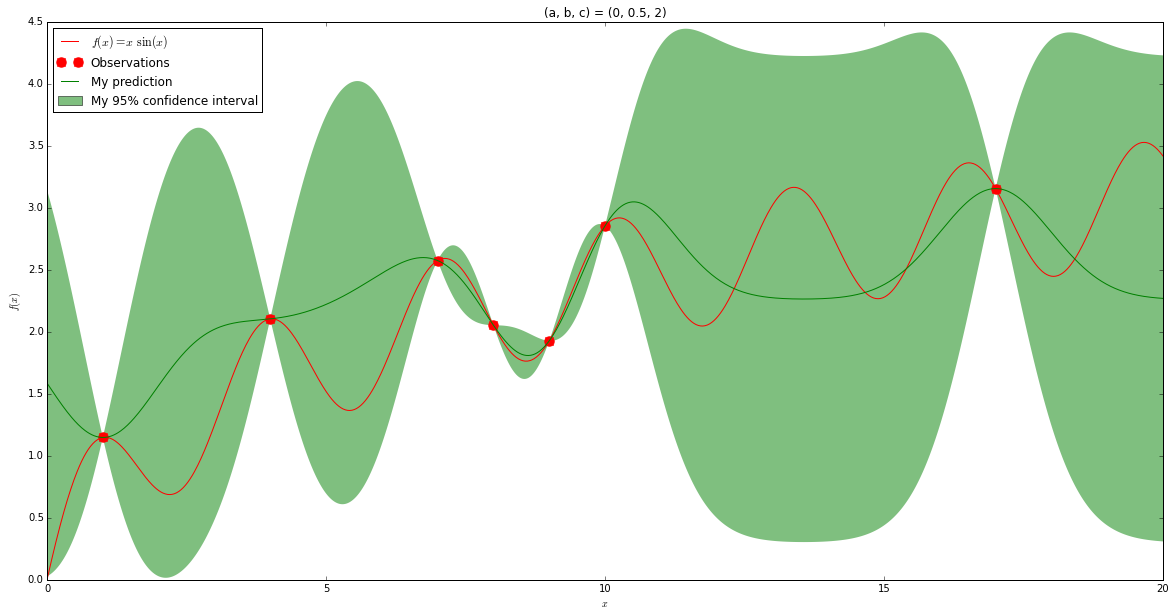

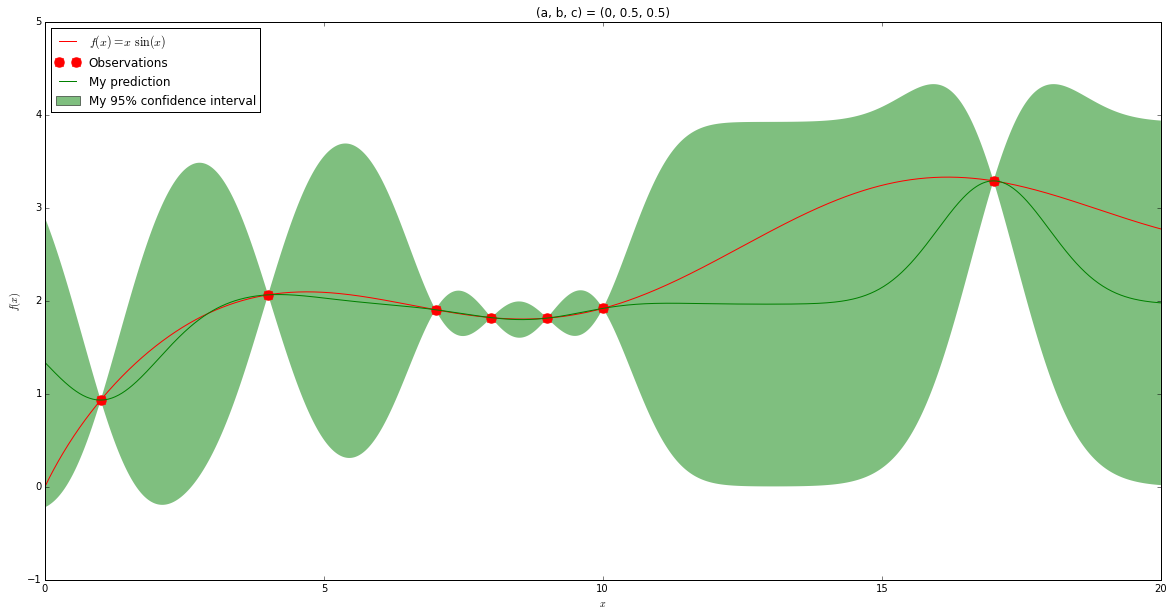

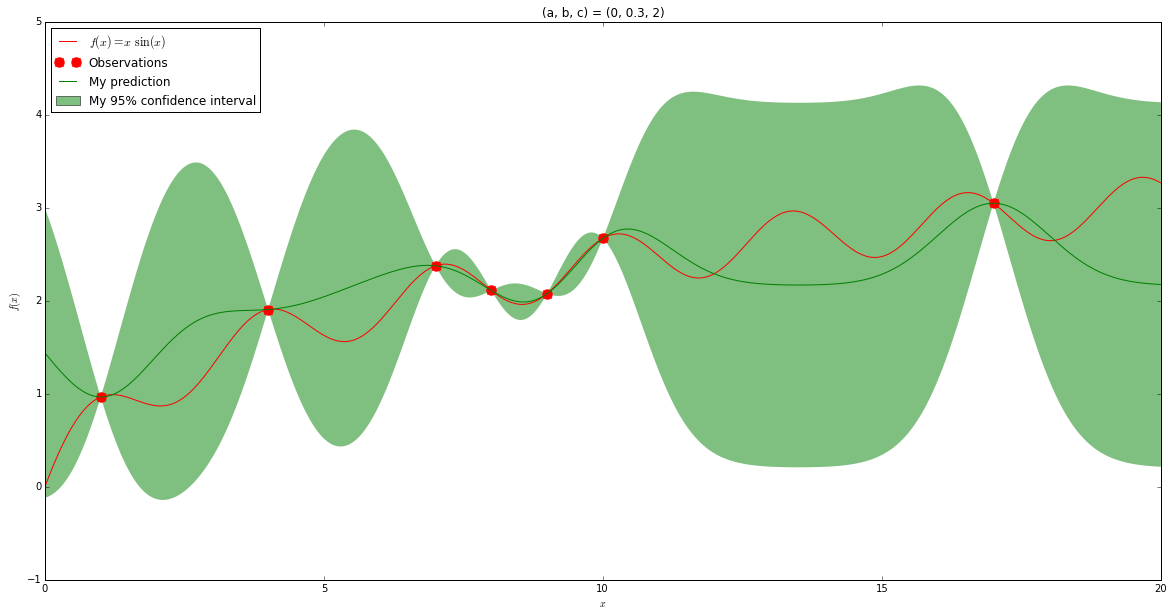

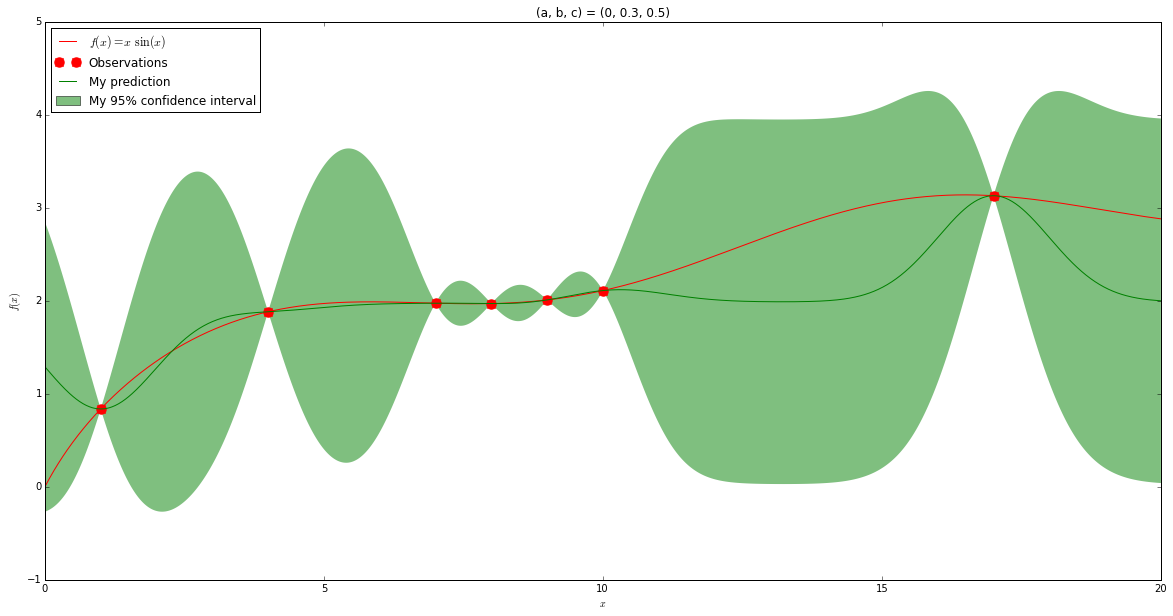

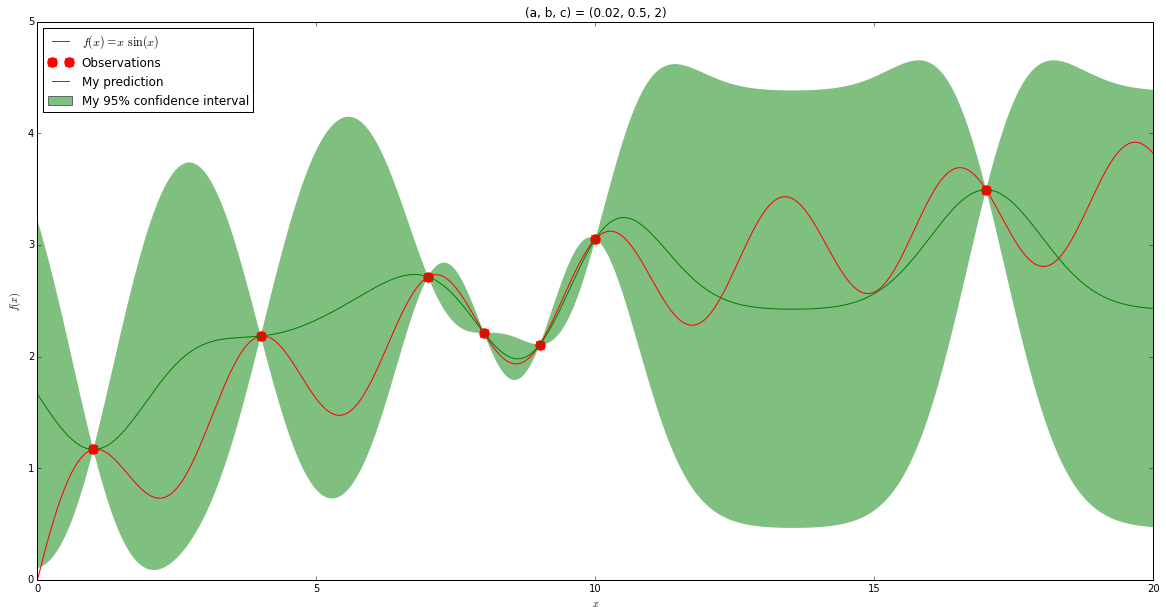

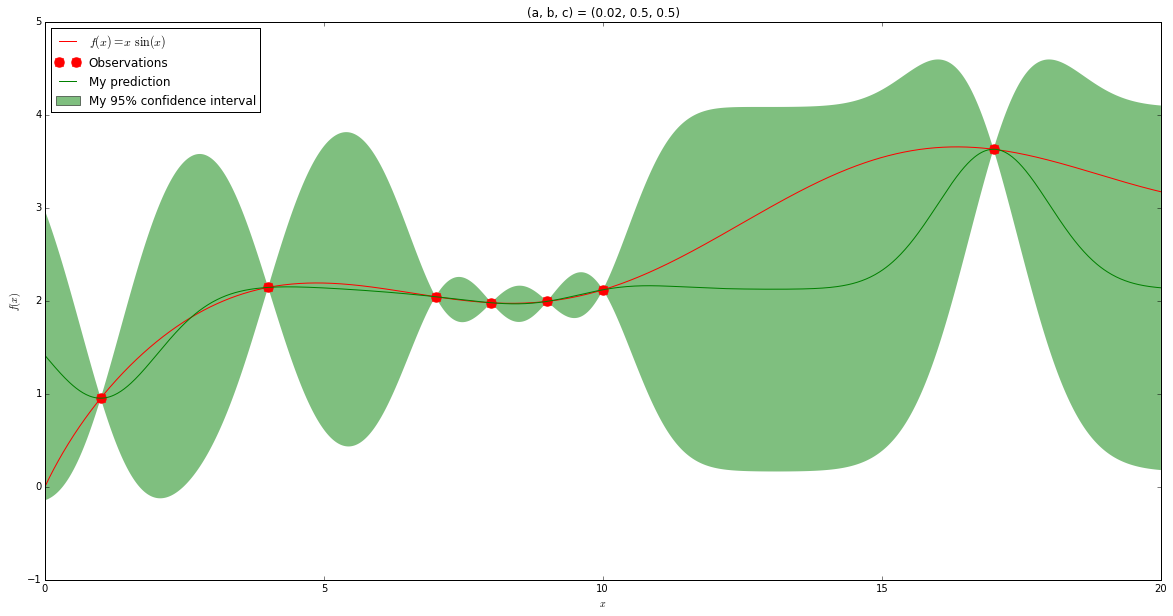

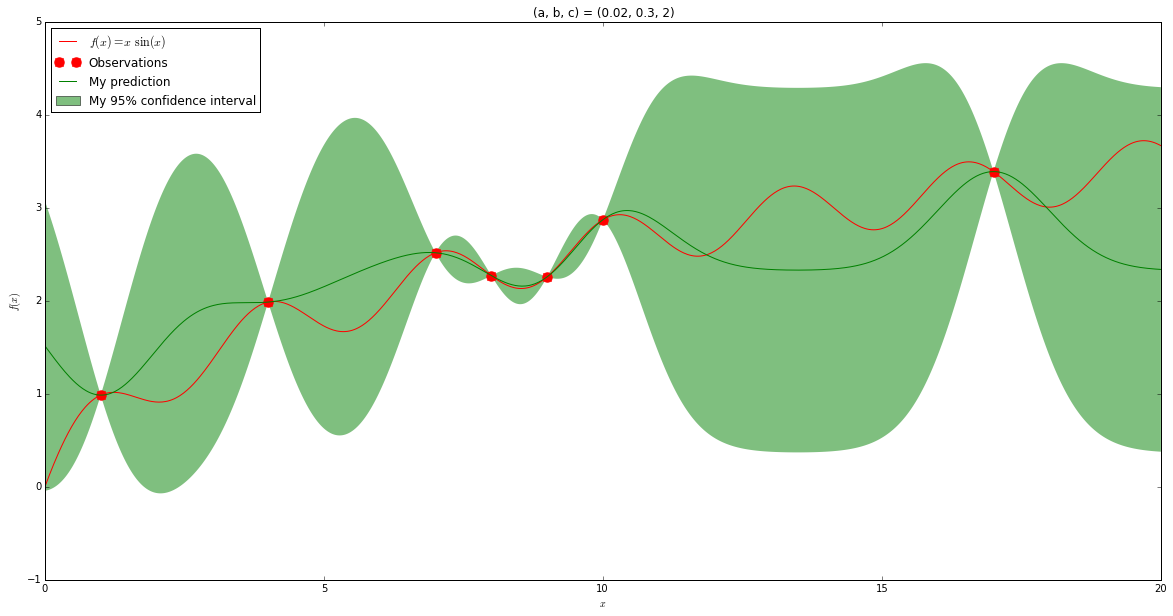

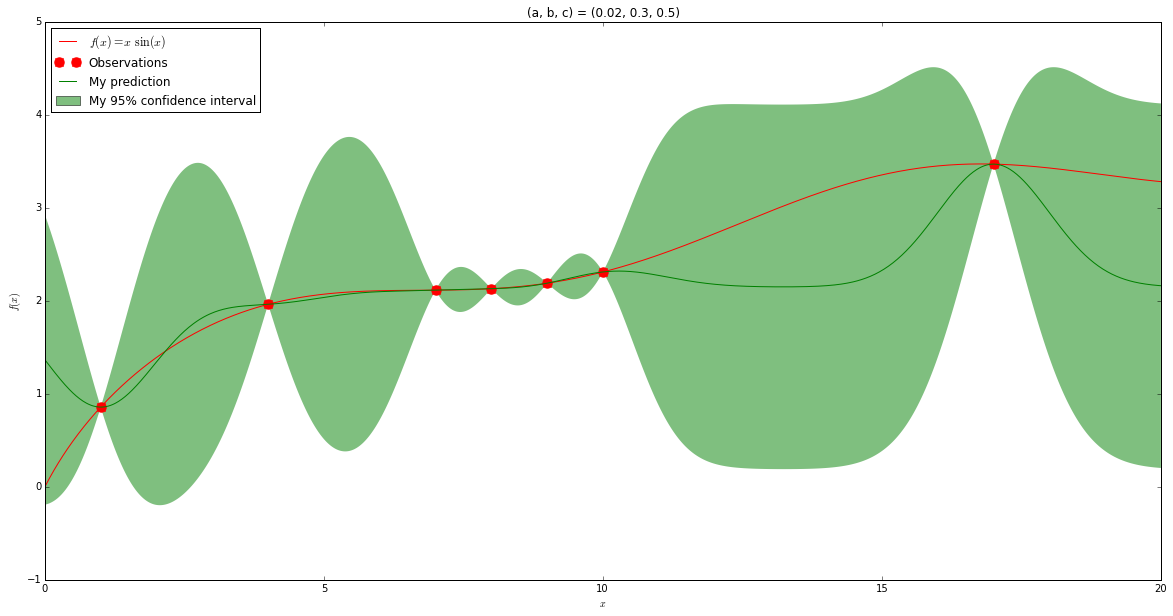

In [75]:
  for a in [0, 0.02]:
    for b in [0.5, 0.3]:
        for c in [2, 0.5]:
            test(gregression_smart, a, b, c)

Ну вот, в точках, где мало информации, получается лучше.